In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_word.pkl")

In [4]:
# Filter out empty rows
print(len(tokens))
tokens = [x for x in tokens if x.shape[0] > 0]
print(len(tokens))

367208
367208


In [5]:
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, random_state=9)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, random_state=9)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 1) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 97937703
Unknown Percentage: 11.25 %


In [7]:
bptt = 50
batch_size = 64
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 1:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(1, 35707),
 (2, 23571),
 (3, 19016),
 (5, 16390),
 (4, 13112),
 (19, 7755),
 (6, 5851),
 (8, 4863),
 (10, 4395),
 (32, 4220)]

In [9]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(1, 13111),
 (20, 9225),
 (6, 4395),
 (16, 1642),
 (23, 1119),
 (45, 1033),
 (109, 993),
 (36, 927),
 (29, 876),
 (95, 846)]

In [10]:
mapping = joblib.load("../data/mapping_word.pkl")

In [11]:
itos = ['<pad>'] + ['<unk>'] *  n_tok
for k, v in mapping.items():
    itos[v] = k

In [12]:
itos[4]

'。'

In [13]:
path = Path("../data/cache/lm_word/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=0, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

### QRNN Model

In [ ]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [ ]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [ ]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_lr()

In [ ]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [14]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.7, 0.99)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 88%|████████▊ | 5362/6120 [18:27<02:36,  4.84it/s, loss=18.9]

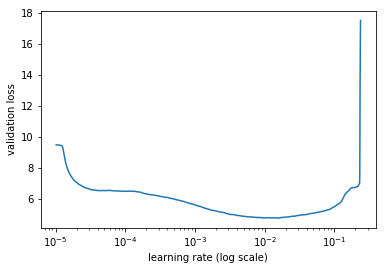

In [15]:
learner.clip = 10.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [15]:
lrs = 3e-3
learner.clip = 10.
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.736591   4.668442  
    1      4.648549   4.510971                                  
    2      4.637241   4.52023                                   
    3      4.625277   4.481868                                  
    4      4.566185   4.425078                                  
    5      4.535305   4.38997                                   
    6      4.515515   4.358727                                  
    7      4.487952   4.329127                                  
    8      4.503434   4.303454                                  
    9      4.47837    4.276612                                  



[4.276612449269266]

In [16]:
learner.save("lm_lstm")

In [17]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.471348   4.278106  
    1      4.463167   4.287122                                  
    2      4.469346   4.297201                                  
    3      4.470476   4.296793                                  
    4      4.475106   4.289094                                  
 38%|███▊      | 9263/24484 [12:49<21:04, 12.04it/s, loss=4.48]

KeyboardInterrupt: 

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [ ]:
# Use tons of memory...
# pred, targ = learner.predict_with_targs(is_test=True)

In [ ]:
tmp_iter = iter(trn_loader)

In [ ]:
next(tmp_iter)[0].shape

In [18]:
learner.load("lm_lstm")

## Test the model

In [19]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(24393, 300, padding_idx=0)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(24393, 300, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=24393, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [28]:
!pip install jieba
import jieba

    100% |################################| 7.3MB 1.9MB/s ta 0:00:0111
  Running setup.py bdist_wheel for jieba ... done
  Stored in directory: /home/docker/.cache/pip/wheels/c9/c7/63/a9ec0322ccc7c365fd51e475942a82395807186e94f0522243
Successfully built jieba


In [23]:
texts = "德国 是 世界 大国 之一 ， 其 国内 生产总值 以 国际 汇率 计"
tokens = list(map(lambda x: mapping.get(x, 1), texts.split(" ")))
tokens

[298, 7, 148, 7074, 226, 2, 42, 870, 6259, 25, 154, 11036, 3299]

In [24]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([13, 24393])

In [25]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": list(texts.split(" ")) + [" "], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,德国,,,
1,是,的,<unk>,、
2,世界,最,世界,<unk>
3,大国,第一,最,上
4,之一,。,，,的
5,，,。,，,的
6,其,<unk>,而,但
7,国内,<unk>,主要,地位
8,生产总值,生产总值,<unk>,的
9,以,为,是,则


In [26]:
def eval(texts):
    learner.model[0].reset()
    tokens = list(map(lambda x: mapping.get(x, 1), texts))
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": [x for x in texts] + [" "], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [29]:
eval(list(jieba.cut("在现代印刷媒体，卡通是一种通常有幽默色")))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.525 seconds.
Prefix dict has been built succesfully.


,orig,pred_1,pred_2,pred_3
0,在,,,
1,现代,<unk>,中国,此
2,印刷,的,<unk>,社会
3,媒体,的,中,，
4,，,中,上,的
5,卡通,<unk>,并,以
6,是,<unk>,的,和
7,一种,<unk>,一,在
8,通常,的,<unk>,，
9,有,的,<unk>,在


In [30]:
eval(list(jieba.cut("对中国与南洋发动全面的战争。1990年代，中")))

,orig,pred_1,pred_2,pred_3
0,对,,,
1,中国,<unk>,此,其
2,与,的,大陆,<unk>
3,南洋,中国,日本,台湾
4,发动,的,地区,、
5,全面,了,的,<unk>
6,的,的,<unk>,战争
7,战争,<unk>,攻击,战争
8,。,。,，,；
9,1990,,<unk>,在


### Generate Sentence

In [33]:
import random

def get_tokens(texts, seg=True):
    if seg:
        texts = list(jieba.cut(texts))
    return list(map(lambda x: mapping.get(x, 1), texts))

def generate_text(tokens,N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            candidate = np.random.choice(candidates, p=probs[candidates])
            if candidate > 1:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(preds[-1])
        # tokens = [:1]
        print("".join([itos[x] for x in tokens])) 
    
generate_text(get_tokens("德国是世界大国之一，其国内生产总值以国际汇率为主，"))

[0.07845 0.05266 0.04809] 0.00010213052
德国是<unk>之一，其国内生产总值以国际汇率为主，十
[0.51401 0.11231 0.09117] 0.5140138
德国是<unk>之一，其国内生产总值以国际汇率为主，十年
[0.15643 0.12442 0.10501] 0.124419756
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后
[0.26499 0.11463 0.04732] 0.00067782955
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了
[0.03007 0.03001 0.0246 ] 0.006189509
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定
[0.0592  0.03512 0.03437] 0.0018525779
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期
[0.13655 0.0554  0.04897] 7.03813e-05
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂
[0.51255 0.07831 0.03414] 0.51254594
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的
[0.2042  0.07072 0.02253] 0.009841645
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的政治
[0.07701 0.0682  0.06336] 0.0034091698
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的政治气候
[0.63012 0.13928 0.05908] 0.6301237
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的政治气候，
[0.06032 0.03049 0.02442] 6.559916e-06
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的政治气候，瞬间
[0.06304 0.02615 0.02359] 0.0003391894
德国是<unk>之一，其国内生产总值以国际汇率为主，十年后为了稳定长期复杂的政治气候，瞬间卷入
[0.25861 0.0973

In [34]:
generate_text(get_tokens("德国 是 世界 大国 之一 ， 其 国内 生产 总 值 以 国际 汇率 为主 ，".split(" "), seg=False))

[0.07781 0.04344 0.0422 ] 8.371915e-05
德国是世界大国之一，其国内生产总值以国际汇率为主，排
[0.5791  0.04529 0.04371] 0.5790994
德国是世界大国之一，其国内生产总值以国际汇率为主，排在
[0.08871 0.06025 0.05663] 0.043066986
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二
[0.57436 0.1548  0.06422] 0.5743636
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位
[0.49874 0.34714 0.03853] 0.49873507
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。
[0.1852  0.07714 0.06073] 4.1774725e-05
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部
[0.07366 0.06926 0.05097] 0.07365563
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在
[0.03813 0.02648 0.02014] 0.00086606364
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19
[0.92585 0.02273 0.00977] 0.925852
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19世纪
[0.14921 0.0954  0.07334] 0.020954467
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19世纪后期
[0.11468 0.06735 0.06547] 0.067347266
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19世纪后期，
[0.06228 0.0396  0.0289 ] 0.062281303
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19世纪后期，在
[0.10091 0.04536 0.04307] 0.011501491
德国是世界大国之一，其国内生产总值以国际汇率为主，排在第二位。经济部在19世纪后期，在台湾
[0.10793 0.03512 0.03398] 1.0227723e-0

In [91]:
generate_text(get_tokens("在现代印刷媒体，卡通是一种通常有幽默色"))

[0.57148 0.10214 0.08893] 0.10213592
在现代印刷媒体，卡通是<unk>通常有幽默色，
[0.12241 0.04842 0.02696] 0.00512519
在现代印刷媒体，卡通是<unk>通常有幽默色，被
[0.16758 0.11191 0.06359] 0.02920835
在现代印刷媒体，卡通是<unk>通常有幽默色，被人
[0.27767 0.09662 0.06675] 0.0006173651
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑
[0.20633 0.08822 0.06203] 0.008166621
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，
[0.14941 0.03693 0.03217] 0.002003036
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指
[0.24453 0.09932 0.02587] 0.005567843
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为
[0.31994 0.05797 0.03811] 0.0013306263
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时
[0.22526 0.11243 0.0357 ] 0.00038319558
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的
[0.22117 0.07134 0.01125] 0.00091244903
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他
[0.17724 0.03044 0.0282 ] 0.0008020848
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「
[0.38756 0.00886 0.00842] 0.000650396
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们
[0.32084 0.17149 0.1125 ] 0.17148939
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们的
[0.36169 0.01851 0.01332] 0.00017412976
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们的图像
[0.38612 0.111

In [35]:
generate_text(get_tokens("在现代印刷媒体，第"))

[0.08504 0.06818 0.06074] 0.02500637
在现代印刷媒体，第9
[0.13459 0.06125 0.04664] 0.030996583
在现代印刷媒体，第9卷
[0.0969  0.08753 0.0629 ] 0.006358325
在现代印刷媒体，第9卷由
[0.35964 0.03145 0.01448] 1.7974633e-05
在现代印刷媒体，第9卷由化工
[0.16731 0.07625 0.03606] 0.036059707
在现代印刷媒体，第9卷由化工专家
[0.41738 0.02947 0.02199] 0.00011674958
在现代印刷媒体，第9卷由化工专家审核
[0.48608 0.20592 0.02552] 0.01952854
在现代印刷媒体，第9卷由化工专家审核后
[0.38415 0.03064 0.02981] 0.021977516
在现代印刷媒体，第9卷由化工专家审核后才
[0.08799 0.05267 0.04986] 0.00034258587
在现代印刷媒体，第9卷由化工专家审核后才实施
[0.53146 0.27191 0.02317] 0.53145814
在现代印刷媒体，第9卷由化工专家审核后才实施。
[0.27509 0.11845 0.03967] 0.27509338
在现代印刷媒体，第9卷由化工专家审核后才实施。
[0.34999 0.0422  0.03589] 0.0006392756
在现代印刷媒体，第9卷由化工专家审核后才实施。法国
[0.09464 0.06684 0.02582] 2.4371655e-05
在现代印刷媒体，第9卷由化工专家审核后才实施。法国HD
[0.46511 0.03778 0.02301] 0.0020391832
在现代印刷媒体，第9卷由化工专家审核后才实施。法国HDF
[0.19441 0.13165 0.08699] 0.00014141893
在现代印刷媒体，第9卷由化工专家审核后才实施。法国HDF.
[0.30597 0.12904 0.02071] 0.1290385
在现代印刷媒体，第9卷由化工专家审核后才实施。法国HDF.是
[0.14171 0.12552 0.10233] 0.00020001286
在现代

In [36]:
generate_text(get_tokens("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。"))           

[0.18456 0.08527 0.05694] 0.18455671
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。
[0.34377 0.0461  0.03459] 0.00032342097
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九
[0.15202 0.05443 0.04422] 0.00053708686
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书
[0.12713 0.10896 0.06299] 1.5963882e-05
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加
[0.59347 0.05559 0.03777] 0.59346837
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了
[0.16312 0.06443 0.03932] 0.0021941084
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七
[0.30051 0.09204 0.06165] 0.30051193
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个
[0.10479 0.03752 0.03398] 0.0014496067
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个年级
[0.24135 0.14488 0.07724] 0.14487728
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个年级学生
[0.22152 0.13946 0.04149] 0.020714818
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个年级学生和
[0.246   0.07621 0.06824] 9.907548e-07
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个年级学生和成效
[0.21746 0.07187 0.04898] 0.0004736853
日本后来成为<unk>的轴心国之一，对中国与南洋发动全面的战争。九书增加了七个年级学生和成效参与
[0.17607 0.17385 0.03965] 0.016922804
日本后来成为<unk>的轴心国之一

In [37]:
generate_text(get_tokens("传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制"
                         "。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基"
                         "础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与"
                         "战国"))           

[0.46438 0.176   0.05057] 0.0505674
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的六百年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国的
[0.2676  0.05387 0.02256] 0.00027404854
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的六百年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国的资本主义
[0.1385  0.13762 0.07186] 0.07185615
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的六百年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国的资本主义制度
[0.42288 0.39987 0.03587] 0.4228803
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的中央集权体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的六百年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国的资本主义制度。
[0.11405 0.07251 0.04429] 0.0009164135
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<

In [38]:
generate_text(get_tokens("特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富"))

[0.10046 0.07854 0.04845] 0.012627744
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足
[0.77163 0.03732 0.01321] 0.0028353613
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一
[0.20588 0.15337 0.12317] 0.015922893
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍
[0.74628 0.03113 0.02749] 0.7462765
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，
[0.08947 0.08114 0.03271] 0.010085421
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将
[0.35467 0.04349 0.02761] 0.35466844
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会
[0.04675 0.04592 0.0306 ] 0.0055490164
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会引发
[0.10218 0.03045 0.02726] 0.018784117
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会引发中国
[0.19296 0.10781 0.05721] 0.19296469
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会引发中国大陆
[0.24402 0.04013 0.03667] 0.0010175591
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会引发中国大陆中部
[0.21184 0.07667 0.04107] 0.0042955666
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富不足一倍，将会引发中国大陆

In [39]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地"))

[0.53561 0.26385 0.0271 ] 0.5356056
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。
[0.29567 0.10711 0.03843] 0.02079274
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而
[0.15756 0.15462 0.03683] 0.036831804
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港
[0.1532  0.0645  0.03328] 0.0023465073
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区
[0.69043 0.03445 0.01556] 0.69043
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府
[0.12213 0.11858 0.08772] 0.0035020853
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并
[0.28014 0.22292 0.18848] 0.18848261
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并不
[0.11025 0.07209 0.04711] 0.010015272
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并不在
[0.10584 0.07783 0.07556] 0.07556277
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并不在香港
[0.12051 0.092   0.07096] 0.002788846
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并不在香港兴建
[0.13735 0.08461 0.05968] 0.036508825
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地。而香港特区政府并不在香港兴建一个
[0.11818 0.07343 0.0734 ] 0.001885635
香港有半

In [40]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，"
                         "呈现出一个与天际线中的香港不同的景象"))

[0.52148 0.36864 0.0094 ] 0.00017321824
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会
[0.06992 0.0674  0.06143] 0.06991685
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被
[0.06367 0.0596  0.05485] 0.00084782025
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解
[0.44276 0.12413 0.11418] 0.008236747
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在
[0.11986 0.05162 0.02879] 9.1968206e-05
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在广义
[0.40945 0.22531 0.0814 ] 0.00082443195
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在广义中国
[0.20361 0.07379 0.05724] 0.00017054846
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在广义中国入
[0.15006 0.08147 0.05248] 0.00031420393
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在广义中国入元
[0.29546 0.07231 0.06112] 0.29545942
香港有半数<unk>在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象会被理解在广义中国入元的
[0.12334 0.

In [42]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Insta"))

[0.22248 0.14943 0.14735] 8.31102e-05
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台
[0.41727 0.11    0.082  ] 0.081996776
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，
[0.0625  0.04938 0.03701] 5.9475176e-05
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕
[0.19647 0.15026 0.05191] 2.4764933e-05
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士
[0.11231 0.11133 0.02376] 0.012419443
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及
[0.05653 0.04455 0.04266] 0.0012519377
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球
[0.13554 0.13303 0.03929] 0.133033
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地
[0.51941 0.03426 0.01393] 0.51940936
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地的
[0.13492 0.01441 0.01269] 0.0010259144
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地的海洋
[0.15255 0.02915 0.02531] 0.0001460682
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地的海洋云
[0.14645 0.05912 0.0361 ] 0.0022190318
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地的海洋云资料
[0.19616 0.09811 0.07649] 0.19615789
香港有半数<unk>在公屋，如今这里意外成为<unk>天文台，围绕瑞士及全球各地的海洋云资料，
[0.04253 0.03291 0.02743] 0.0003579836
香港有半数<unk>在公屋，如今这里意外成为<unk